# 4.1 Analysis of A/B testing from Game 2

In [1]:
from game.flaskapp_andrius.api import preprocesser
from game.utils import run_query
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns

from game.src.delta12_calculator import get_delta12_api, get_recipe_id_api, get_recipe_api, get_delta12
from game.src.ab_test_preprocessor import calc_new_delta, get_last_order_hist, get_all_orders, get_order_hist_from_observed
from game.src.feature_generator import get_embedding, get_vector_list

# Inputs

In [2]:
order_history = pd.read_csv('../data/order_history_g2.csv', sep=',')

In [3]:
g_observed = pd.read_csv('../data/database2.csv')

# Change csv output path at the end

# Preprocessing

In [4]:
g_observed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   record_id    769 non-null    int64  
 1   customer_id  768 non-null    float64
 2   o1_c1        769 non-null    int64  
 3   o1_c2        769 non-null    int64  
 4   o1_c3        769 non-null    int64  
 5   o1_c4        769 non-null    int64  
 6   o1_c5        769 non-null    int64  
 7   o1_c6        769 non-null    int64  
 8   o1_c7        769 non-null    int64  
 9   o1_c8        769 non-null    int64  
 10  o1_c9        769 non-null    int64  
 11  o1_c10       769 non-null    int64  
 12  o2_c1        769 non-null    int64  
 13  o2_c2        769 non-null    int64  
 14  o2_c3        769 non-null    int64  
 15  o2_c4        769 non-null    int64  
 16  o2_c5        769 non-null    int64  
 17  o2_c6        769 non-null    int64  
 18  o2_c7        769 non-null    int64  
 19  o2_c8   

In [5]:
recipe_cols = g_observed.columns[2:22]
recipe_cols

Index(['o1_c1', 'o1_c2', 'o1_c3', 'o1_c4', 'o1_c5', 'o1_c6', 'o1_c7', 'o1_c8',
       'o1_c9', 'o1_c10', 'o2_c1', 'o2_c2', 'o2_c3', 'o2_c4', 'o2_c5', 'o2_c6',
       'o2_c7', 'o2_c8', 'o2_c9', 'o2_c10'],
      dtype='object')

In [6]:
# Preprocessing order history table
order_history = order_history.reset_index()
order_history.columns = order_history.iloc[0].tolist()
order_history = order_history.drop(0)
order_history = order_history.dropna(subset=['id'])
order_history['id'] = order_history['id'].astype(int)
order_history['delivery_id'] = order_history['delivery_id'].astype(int)
order_history['customer_id'] = order_history['customer_id'].astype(int)
order_history.head(1)

,delivery_id,delivery_date,customer_id,allergens,calories,carbs,cuisine,fat,food_group,protein,...,id,cooking_time,image_url,instructions,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence
1,8089256,2020-03-28,100043,{Celery},623.40,75.50,Mexican,22.81,Vegan,26.84,...,570,30,https://mindfulchef-uat.imgix.net/recipes/570/...,Boil a kettle. Rinse the brown rice and place ...,Sunflower family organic sunflower mince,"Sunflower 'mince' chilli, kidney beans & guac","It’s all the comfort of chilli con carne, minu...",900,1200,2200


In [7]:
g_customers = order_history['customer_id'].unique()
g_historical = pd.DataFrame(g_customers, columns=['customer_id'])

In [8]:
# Get updated recipes info and vectors associated with recipes
df_updated_recipes = pd.read_csv('../data/recipe_table_updated_UAT.csv', sep=',')
df_updated_recipes = df_updated_recipes.reset_index()
df_updated_recipes.columns = df_updated_recipes.iloc[0].tolist()
df_updated_recipes = df_updated_recipes.drop(0)
df_updated_recipes['id'] = df_updated_recipes['id'].astype(int)
df_updated_recipes = df_updated_recipes.dropna(subset=['key_ingredient'])

updated_recipe_dict = df_updated_recipes.to_dict(orient='records')
list_of_updated_vectors = get_vector_list(updated_recipe_dict)
df_updated_recipes['vector'] = list_of_updated_vectors
df_updated_recipes.head(1)

,allergens,calories,carbs,cuisine,fat,food_group,protein,season,special,id,cooking_time,image_url,instructions,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence,vector
1,"{Mustard,Nuts}",505.84,26.63,British,26.52,Beef,45.71,Spring,NaN,1,25,https://mindfulchef-uat.imgix.net/recipes/1/2e...,"Preheat the oven to 180C / gas mark 4., Trim t...",Grass-fed heritage breed Yorkshire beef,Seared beef with spring vegetable medley,We've paired a succulent seared steak with a m...,900,1400,2400,"[0.0647217469599511, -0.003410175382256585, -0..."


In [9]:
# Preprocessing of observed data from AB testing
g_observed = g_observed.dropna(subset=['customer_id'])
g_observed['customer_id'] = g_observed['customer_id'].astype(int)
g_observed[recipe_cols] = g_observed[recipe_cols].replace(0, np.nan)

In [10]:
# Generate recipe vectors from old recipe table
df_recipes = pd.read_csv('../data/recipe_table.csv', sep=';')
df_recipes['price'] = df_recipes['price_2p_pence']

df_clean = df_recipes[['id', 'food_group', 'calories', 'carbs', 'fat',
                      'protein', 'cooking_time', 'title', 'description',
                      'key_ingredient', 'price']]
recipe_dict = df_clean.to_dict(orient='records')
list_of_vectors = get_vector_list(recipe_dict)
df_clean['vector'] = list_of_vectors
df_vectors = pd.DataFrame(df_clean[['id', 'vector']])

# Historical delta12 and magnitude

In [11]:
# Get historical delta12 values for game-playing customers (can take time)
g_historical['historical_delta12'] = g_historical['customer_id'].apply(lambda x: get_delta12(get_last_order_hist(order_history, x)))

In [12]:
# Get historical pairwise magnitudes for game-playing customers (can take time)
g_historical['historical_magnitude'] = g_historical['customer_id'].apply(lambda x: calc_new_delta(get_all_orders(order_history, x), df_updated_recipes))

In [13]:
g_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           683 non-null    int32  
 1   historical_delta12    683 non-null    float64
 2   historical_magnitude  681 non-null    float64
dtypes: float64(2), int32(1)
memory usage: 13.5 KB


<AxesSubplot:xlabel='historical_delta12', ylabel='Density'>

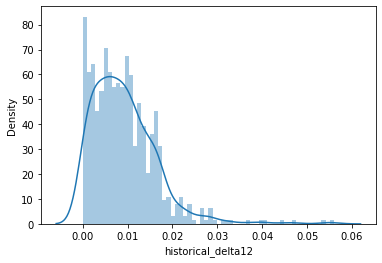

In [14]:
sns.distplot(g_historical['historical_delta12'], bins=60)

<AxesSubplot:xlabel='historical_magnitude', ylabel='Density'>

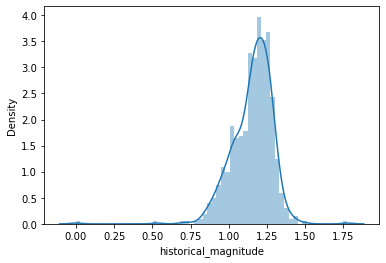

In [15]:
sns.distplot(g_historical['historical_magnitude'], bins=60)

In [16]:
# Sort by customer ID
g_historical = g_historical.sort_values('customer_id')
g_historical.head(5)

,customer_id,historical_delta12,historical_magnitude
424,59,0.005561,0.942365
201,128,0.008832,1.371839
251,212,0.023784,1.290959
296,334,0.015519,1.087852
299,343,0.013749,1.281169


# Observed delta12 and magnitude from AB testing

In [17]:
# Get observed delta12 values
g_observed['observed_delta12'] = g_observed['customer_id'].apply(lambda x: get_delta12(get_order_hist_from_observed(g_observed, x, recipe_cols)))
g_observed.head(1)

,record_id,customer_id,o1_c1,o1_c2,o1_c3,o1_c4,o1_c5,o1_c6,o1_c7,o1_c8,...,o2_c2,o2_c3,o2_c4,o2_c5,o2_c6,o2_c7,o2_c8,o2_c9,o2_c10,observed_delta12
0,1,81384,583,308,39.0,455.0,NaN,NaN,NaN,NaN,...,445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003498


In [18]:
# Get observed magnitudes (this takes some time to run)
g_observed['observed_magnitude']=0
for i in range(len(g_observed)):
    g_observed['observed_magnitude'].iloc[i] = calc_new_delta(g_observed[recipe_cols].iloc[i].dropna().tolist(), df_vectors)

In [19]:
g_observed_clean = g_observed[['customer_id', 'observed_delta12', 'observed_magnitude']]
g_observed_clean = g_observed_clean.sort_values('customer_id')
g_observed_clean.head(5)

,customer_id,observed_delta12,observed_magnitude
205,59,0.000303,1.194599
91,128,0.015780,1.107327
474,212,0.024779,1.062521
377,334,0.014333,1.182200
458,343,0.006960,0.980015


In [20]:
g_historical.head(5)

,customer_id,historical_delta12,historical_magnitude
424,59,0.005561,0.942365
201,128,0.008832,1.371839
251,212,0.023784,1.290959
296,334,0.015519,1.087852
299,343,0.013749,1.281169


# Merge and export

In [21]:
g_merged = pd.merge(g_historical, g_observed_clean, on='customer_id')

In [22]:
g_merged['diff_delta12'] = g_merged['observed_delta12'] - g_merged['historical_delta12']
g_merged['diff_magnitude'] = g_merged['observed_magnitude'] - g_merged['historical_magnitude']
g_merged.head()

,customer_id,historical_delta12,historical_magnitude,observed_delta12,observed_magnitude,diff_delta12,diff_magnitude
0,59,0.005561,0.942365,0.000303,1.194599,-0.005258,0.252234
1,128,0.008832,1.371839,0.015780,1.107327,0.006948,-0.264512
2,212,0.023784,1.290959,0.024779,1.062521,0.000995,-0.228438
3,334,0.015519,1.087852,0.014333,1.182200,-0.001186,0.094348
4,343,0.013749,1.281169,0.006960,0.980015,-0.006789,-0.301153


<AxesSubplot:xlabel='diff_delta12', ylabel='Density'>

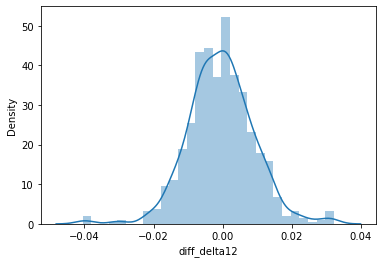

In [23]:
sns.distplot(g_merged['diff_delta12'])

<AxesSubplot:xlabel='diff_magnitude', ylabel='Density'>

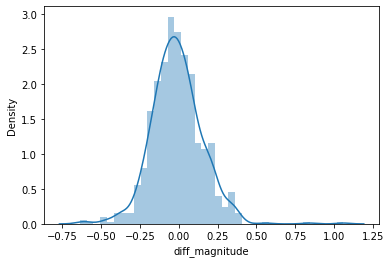

In [24]:
sns.distplot(g_merged['diff_magnitude'])

In [25]:
g_merged['diff_delta12'].describe()

count    755.000000
mean      -0.000499
std        0.009623
min       -0.040500
25%       -0.006311
50%       -0.000422
75%        0.005333
max        0.032217
Name: diff_delta12, dtype: float64

In [26]:
g_merged['diff_magnitude'].describe()

count    753.000000
mean      -0.011380
std        0.164395
min       -0.637185
25%       -0.114491
50%       -0.020552
75%        0.083675
max        1.059989
Name: diff_magnitude, dtype: float64

In [28]:
# Export data
g_merged[['diff_delta12', 'diff_magnitude']].to_csv('../data/g2_diff.csv', index=False)